## Prompt

In this notebook, I explore an "exact" and simulation approach to solving the [538 Riddler from March 27th](https://fivethirtyeight.com/features/can-you-get-the-gloves-out-of-the-box/)

>You start with a fair 6-sided die and roll it six times, recording the results of each roll. You then write these numbers on the six faces of another, unlabeled fair die. For example, if your six rolls were 3, 5, 3, 6, 1 and 2, then your second die wouldn’t have a 4 on it; instead, it would have two 3s.
>
>Next, you roll this second die six times. You take those six numbers and write them on the faces of yet another fair die, and you continue this process of generating a new die from the previous one.
>
>Eventually, you’ll have a die with the same number on all six faces. What is the average number of rolls it will take to reach this state?
>
>Extra credit: Instead of a standard 6-sided die, suppose you have an N-sided die, whose sides are numbered from 1 to N. What is the average number of rolls it would take until all N sides show the same number?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multinomial
from scipy.special import binom
from collections import Counter
from itertools import product, permutations
from copy import deepcopy
import pandas as pd

import pathos.multiprocessing as mp

## Exact Solution

Idea: the rolling process is a Markov process with an absorbing state, in which the sides are all identical. As such, we can find the mean-time to all identical sides by finding the average time to absorprtion for the Markov process.

To do this, we first need to specify the states of this Markov process and determine its transition probabilities.

I was a bit lazy this week, so I use a very wasteful method to compute the transition probabilities by direct counting.

In [2]:
def distinct_permutations(s_type):    
    n_distinct = len(s_type)
    return list(set(permutations(s_type, r = len(s_type))))

In [3]:
# http://jeromekelleher.net/generating-integer-partitions.html
def rule_asc(n):
    a = [0 for i in range(n + 1)]
    k = 1
    a[1] = n
    while k != 0:
        x = a[k - 1] + 1
        y = a[k] - 1
        k -= 1
        while x <= y:
            a[k] = x
            y -= x
            k += 1
        a[k] = x + y
        yield a[:k + 1]

def ascending_partitions(n):
    return list(rule_asc(n))

def descending_partitions(n):
    return list(map(lambda s: list(reversed(s)), ascending_partitions(n)))

In [4]:
def transition_prob(i_type, j_type, n_sides):
    qi = (1.0 / n_sides) * np.array(i_type)
    
    if len(j_type) < len(i_type):
        n_pad = len(i_type) - len(j_type)
        j_type = j_type + [0]*n_pad
    
    p_ij = 0
    for e in distinct_permutations(j_type):
        p_ij += multinomial.pmf(e, n =n_sides, p = qi)
    
    return p_ij

def transition_matrix(n_sides):
    s_types = descending_partitions(n_sides)
    n_types = len(s_types)
    
    p = np.zeros((n_types, n_types))
    
    for i in range(n_types):
        i_type = s_types[i]
        
        for j in range(n_types):
            j_type = s_types[j]

            if len(j_type) <= len(i_type):
                p[i, j] = transition_prob(i_type, j_type, n_sides)
                
    return p, n_types, [''.join([str(k) for k in s]) for s in s_types]

Solve the problem for 2 - 10 sided dies.

In [5]:
ps = dict()
mus = dict()
average_relabelings_exact = dict()
states = dict()

for n_sides in range(2,10+1):
    # Generate the transition matrices
    p, n_types, s_types = transition_matrix(n_sides)
       
    # Solve for the mean time to absorption (mu)
    R = p[:-1,:-1]
    mu = np.linalg.solve(np.eye(n_types - 1, n_types - 1) - R, np.ones((n_types - 1,1)))
    
    # Append result to dict
    ps[n_sides] = deepcopy(p)
    mus[n_sides] = deepcopy(mu)
    average_relabelings_exact[n_sides] = mus[n_sides][0].item()
    states[n_sides] = deepcopy(s_types)

Plot the transition matrices for 2 - 6 sided dice.

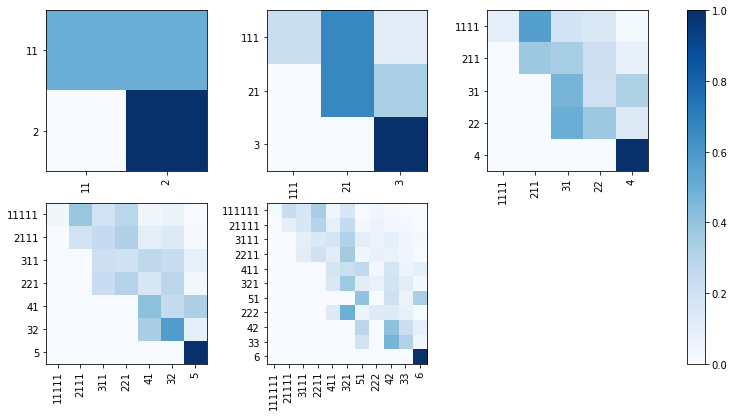

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(14,6.5))

for n_sides in range(2,6+1):
    i, j = (n_sides - 2) // 3, (n_sides-2) % 3
    im = axs[i][j].imshow(ps[n_sides], cmap='Blues')
    
    axs[i][j].set_xticks(np.arange(len(states[n_sides])))
    axs[i][j].set_xticklabels(states[n_sides], rotation=90)

    axs[i][j].set_yticks(np.arange(len(states[n_sides])))
    axs[i][j].set_yticklabels(states[n_sides], rotation=0)

fig.delaxes(axs[1, 2])
fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()


## Simulation 
Here I just simulate the process and see how long it took on average. 

In [7]:
# https://stackoverflow.com/questions/3844801/check-if-all-elements-in-a-list-are-identical
def check_equal(iterator):
    iterator = iter(iterator)
    try:
        first = next(iterator)
    except StopIteration:
        return True
    return all(first == rest for rest in iterator)

def roll_until_same_face(n_sides):    
    n_relabelings = 0
    faces = np.arange(1, n_sides+1)
    
    while not check_equal(faces):        
        n_relabelings += 1
        faces = np.random.choice(faces, size = n_sides, replace=True)
    
    return n_relabelings

def repeat_roll_until_same_face(n_sides, n_repetitions, n_processors=1):
    n_relabelings = np.zeros(n_repetitions)

    with mp.Pool(n_processors) as p:        
        n_relabelings = p.map(lambda x: roll_until_same_face(n_sides), 
                              np.arange(n_repetitions))
    
    return n_relabelings

In [8]:
n_repetitions = 100000

simulated_relabelings = dict()
average_relabelings_simulated = dict()

for n_sides in range(2, 10+1):
    n_relabelings = repeat_roll_until_same_face(n_sides, n_repetitions, 
                                                n_processors=4)
    simulated_relabelings[n_sides] = deepcopy(n_relabelings)
    average_relabelings_simulated[n_sides] = np.mean(n_relabelings)

## Final Results

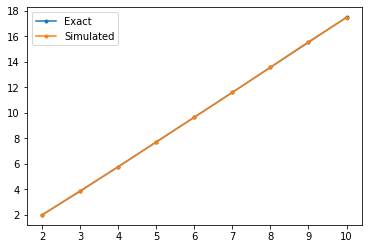

In [9]:
plt.plot(list(average_relabelings_exact.keys()),
         list(average_relabelings_exact.values()), 
         marker='.',
        label='Exact')
plt.plot(list(average_relabelings_simulated.keys()),
         list(average_relabelings_simulated.values()), 
         marker='.', 
         label = "Simulated")
plt.legend()
plt.show()

In [10]:
df = pd.DataFrame({
    'Number of Sides' : list(average_relabelings_exact.keys()),
    'Simulated' : list(average_relabelings_simulated.values()),
    'Exact' : list(average_relabelings_exact.values())}
)

df.style.hide_index()

Number of Sides,Simulated,Exact
2,1.995640,2.000000
3,3.890320,3.857143
4,5.763960,5.779310
5,7.730800,7.711982
6,9.653640,9.655991
7,11.600080,11.608147
8,13.579640,13.566288
9,15.574320,15.529088
10,17.471520,17.495620
